In [15]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Global parameters
DATA_DIR = "/Users/xiuqi/Downloads/Data/Bosch/"
ID_COL = 'Id'
TARGET_COL = 'Response'
SEED = 0
CHUNKSIZE = 10000
NROWS = 50000

In [17]:
TRAIN_NUMERIC = "{0}/train_numeric.csv".format(DATA_DIR)
TRAIN_DATE = "{0}/train_date.csv".format(DATA_DIR)

TEST_NUMERIC = "{0}/test_numeric.csv".format(DATA_DIR)
TEST_DATE = "{0}/test_date.csv".format(DATA_DIR)

#train = pd.read_csv(TRAIN_NUMERIC, usecols=[ID_COL,TARGET_COL],
#                   nrows=NROWS)
#test = pd.read_csv(TEST_NUMERIC, usecols=[ID_COL],nrows=NROWS)
train = pd.read_csv(TRAIN_NUMERIC, nrows=NROWS)
test = pd.read_csv(TEST_NUMERIC, nrows=NROWS)


train['StartTime'] = -1
test['StartTime'] = -1

In [18]:
nrows = 0
for tr, te in zip(pd.read_csv(TRAIN_DATE, chunksize=CHUNKSIZE),
                  pd.read_csv(TEST_DATE, chunksize=CHUNKSIZE)):
    feats = np.setdiff1d(tr.columns,[ID_COL])
    
    stime_tr = tr[feats].min(axis=1).values
    stime_te = te[feats].min(axis=1).values

    train.loc[train.Id.isin(tr.Id),'StartTime'] = stime_tr
    test.loc[test.Id.isin(te.Id),'StartTime'] = stime_te
    
    nrows += CHUNKSIZE
    if nrows >= NROWS:
        break

In [19]:
ntrain = train.shape[0]
train_test = pd.concat((train,test)).reset_index(drop=True).reset_index(drop=False)
train_test.head()

,index,Id,L0_S0_F0,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F2,L0_S0_F20,...,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response,StartTime
0,0,4,0.030,0.116,-0.015,-0.032,0.020,0.083,-0.034,-0.273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,82.24
1,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1313.12
2,2,7,0.088,0.025,-0.015,-0.072,-0.225,-0.147,0.086,0.250,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1618.70
3,3,9,-0.036,0.161,0.022,0.128,-0.026,-0.046,-0.064,-0.253,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1149.20
4,4,11,-0.055,0.025,0.030,0.168,-0.169,-0.099,-0.086,0.042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,602.64


In [20]:
train_test['MagicFeature1'] = train_test[ID_COL].diff().fillna(999999).astype(int)
train_test['MagicFeature2'] = train_test[ID_COL].iloc[::-1].diff().fillna(999999).astype(int)

train_test = train_test.sort_values(by=['StartTime',ID_COL],ascending=True)

train_test['MagicFeature3'] = train_test[ID_COL].diff().fillna(999999).astype(int)
train_test['MagicFeature4'] = train_test[ID_COL].iloc[::-1].diff().fillna(999999).astype(int)

train_test = train_test.sort_values(by=['index']).drop(['index'],axis=1)
train = train_test.iloc[:ntrain,:]
test = train_test.iloc[ntrain:,:]

features = np.setdiff1d(list(train.columns),[TARGET_COL,ID_COL])

In [21]:
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,4

In [40]:
def modelfit(alg, train, feats, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    if useTrainCV == True:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train[feats].values,
                              label = train[TARGET_COL].values)
        cvresults = xgb.cv(xgb_param, xgtrain,
                           num_boost_round = alg.get_params()['n_estimators'],
                           nfold = cv_folds, metrics ='auc',
                           early_stopping_rounds = early_stopping_rounds)
        alg.set_params(n_estimators = cvresults.shape[0])
    n_estimator = cvresults.shape[0] if useTrainCV else alg.get_params()['n_estimators']
        
    # Fit
    alg.fit(train[feats], train[TARGET_COL], eval_metric = 'auc')
    # Predict
    predicts = alg.predict(train[feats])
    predprob = alg.predict_proba(train[feats])[:,-1]
    # Print results
    print('\n Model Report')
    print('Accuracy: {0:.4f}'.format(metrics.accuracy_score(train[TARGET_COL].values,
                                                            predicts)))
    print('AUC Score: {0:.4f}'.format(metrics.roc_auc_score(train[TARGET_COL].values,
                                                            predprob)))
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    plt.figure(figsize=(int(len(feat_imp)/5),10))
    feat_imp.plot(kind='bar', title = 'Feature Importances')
    plt.ylabel('Feature Importance Score')
    return n_estimator


 Model Report
Accuracy: 0.9956
AUC Score: 0.9614


42

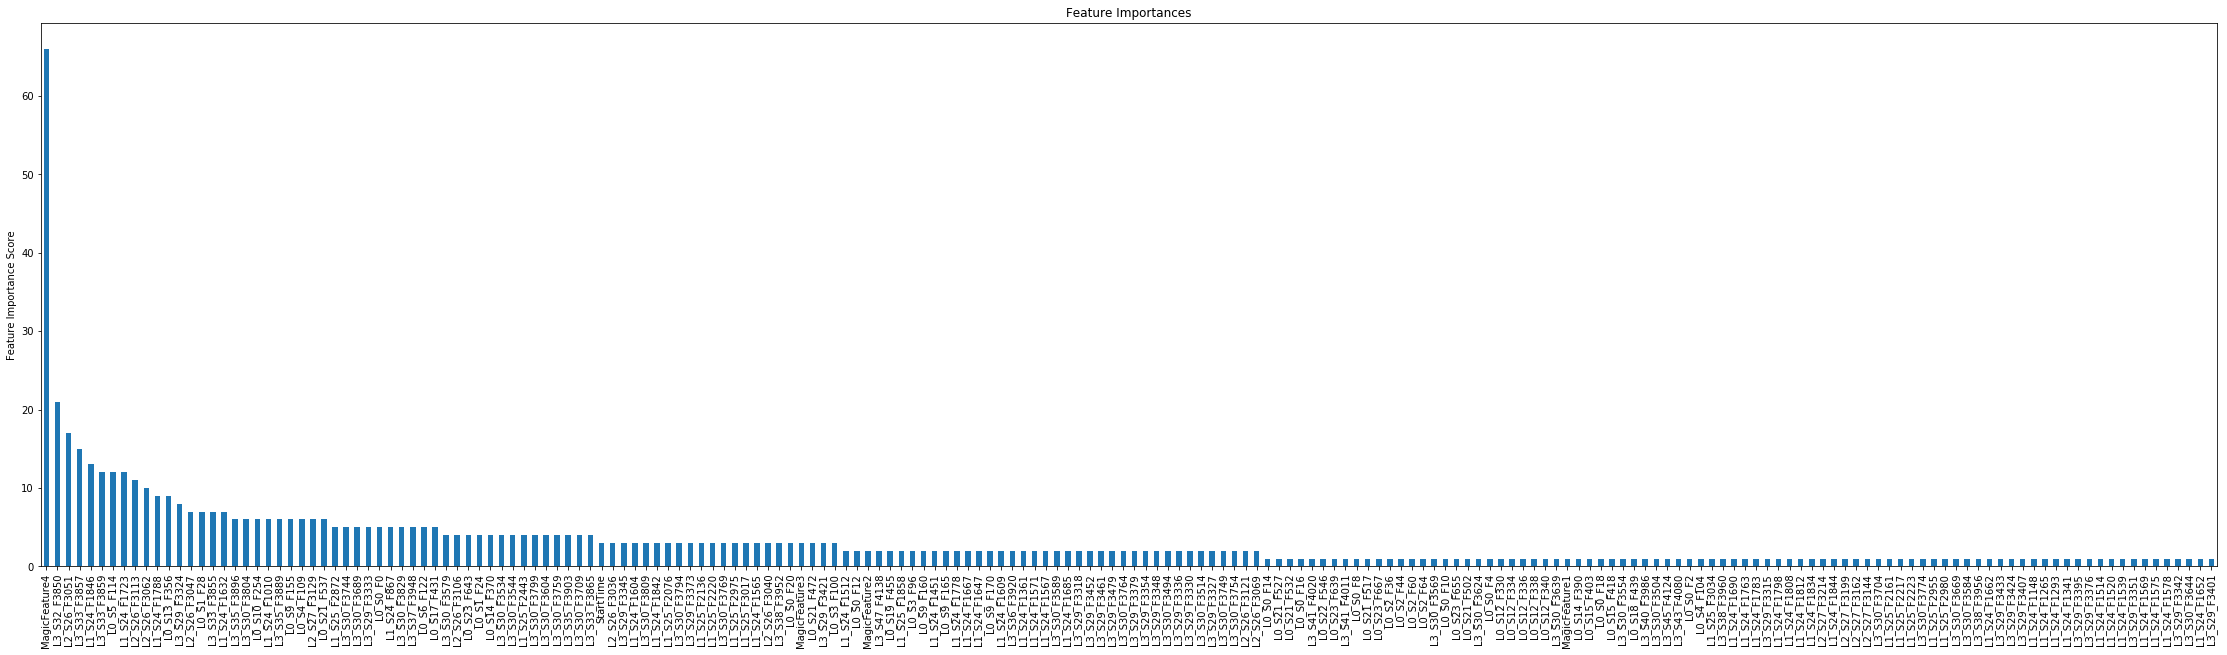

In [41]:
# Choose cols of features
feats = [feat for feat in train.columns.values if feat not in [ID_COL,TARGET_COL]]
xgb1 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = SEED
)
n_estimator = modelfit(xgb1, train, feats)
n_estimator

In [51]:
param_test1 = {
    'max_depth':[3,5,7,9],
    'min_child_weight':[1,3,5]
}
xgb2 = xgb1
xgb2.set_params(n_estimators = n_estimator)
gsearch1 = GridSearchCV(estimator = xgb2,
                        param_grid = param_test1,
                        scoring = 'roc_auc',
                        iid = False,
                        cv = 5)
gsearch1.fit(train[feats],train[TARGET_COL])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.88241, std: 0.02101, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.87213, std: 0.01579, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.87612, std: 0.01459, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.88911, std: 0.01695, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.88243, std: 0.02006, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.88365, std: 0.02111, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.88898, std: 0.01626, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.87815, std: 0.01830, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.88910, std: 0.02405, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.88177, std: 0.01993, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.88062, std: 0.01793, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.88594, std: 0.02063, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [53]:
param_test2 = {
    'n_estimators': [42,1000]
}
xgb3 = XGBClassifier(
    learning_rate = 0.1,
    max_depth = 5,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = SEED
)
gsearch2 = GridSearchCV(estimator = xgb3,
                        param_grid = param_test2,
                        scoring = 'roc_auc',
                        iid = False,
                        cv = 5)
gsearch2.fit(train[feats],train[TARGET_COL])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

KeyboardInterrupt: 

In [54]:
param_test2 = {
    'max_depth': [4,5,6]
}
xgb3 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 42,
    min_child_weight = 1,
    gamma = 0,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = SEED
)
gsearch2 = GridSearchCV(estimator = xgb3,
                        param_grid = param_test2,
                        scoring = 'roc_auc',
                        iid = False,
                        cv = 5)
gsearch2.fit(train[feats],train[TARGET_COL])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.88165, std: 0.01915, params: {'max_depth': 4},
  mean: 0.88911, std: 0.01695, params: {'max_depth': 5},
  mean: 0.88630, std: 0.01814, params: {'max_depth': 6}],
 {'max_depth': 5},
 0.8891110720409522)

In [56]:
param_test3 = {
    'gamma': [i/10.0 for i in range(0,5)]
}
xgb3 = XGBClassifier(
    learning_rate = 0.1,
    n_estimators = 42,
    min_child_weight = 1,
    max_depth = 5,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    seed = SEED
)
gsearch3 = GridSearchCV(estimator = xgb3,
                        param_grid = param_test3,
                        scoring = 'roc_auc',
                        iid = False,
                        cv = 5)
gsearch3.fit(train[feats],train[TARGET_COL])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.88911, std: 0.01695, params: {'gamma': 0.0},
  mean: 0.88920, std: 0.01732, params: {'gamma': 0.1},
  mean: 0.88692, std: 0.01840, params: {'gamma': 0.2},
  mean: 0.88672, std: 0.01963, params: {'gamma': 0.3},
  mean: 0.88739, std: 0.01949, params: {'gamma': 0.4}],
 {'gamma': 0.1},
 0.8892046982420752)